In [1]:
#importing required packages 
!pip install regex
!pip install statsmodels
!pip install imblearn
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
df = pd.read_csv('Project2_Data.csv')
labels = pd.read_csv('Project2_Data_Labels.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0.0,May,1,1,1,2,New_Visitor,True
1,0,0.0,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0.0,Mar,2,2,4,2,Returning_Visitor,False
2,4,37.5,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0.0,Nov,2,2,9,2,New_Visitor,False
3,4,115.7,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0.0,Nov,1,1,2,3,Returning_Visitor,False
4,1,60.0,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0.0,May,2,2,3,4,Returning_Visitor,False


Exploratory Data Analysis


Reviewing size of dataset, along with null counts, and data types

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Does not appear that the data needs much cleaning up. Next the 18 variables in the dataset will be explored in an efficient manner.

The approach of this EDA will be:

-To group variables based on their informational content

-Search for high colinnearity, high correlations and heterogeneity 

-Apply feature engineering methods and how they change the distribution of values

-Fit data to kmeans and hierarchial clustering models

-Observe and interpret results

-Highlight generalizations


The first group of variables are related to the number of pages and time spent on each page.
There are 3 types of pages being observed:

-Administrative

-Informational

-Product Related

Each page type has a pair of variables associated with it, for example:

product_related : the number of product related pages visited by a customer

product_related_duration : the time spent by the customer on each product related page

Factors recording date will alsobe included for the analysis because it may reveal additional insight.

<Axes: >

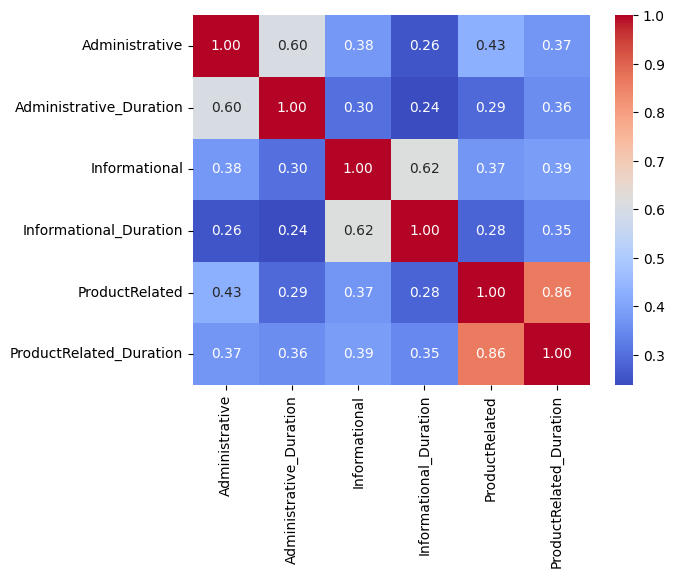

In [9]:
pagetypes = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration' ]
correlations = df[pagetypes].corr()
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt = '.2f')

There should be high correlations between the time spent on the website and the number of pages the customer clicks through. However this assumption is apparent only in the product related pages. This requires further investigation, which can be initiated by looking at total number of pages clicked through for each page caegory. 

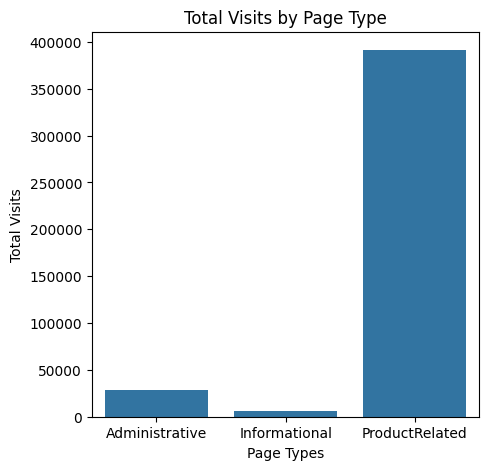

,Page Type,Pages Visited
0,Administrative,28546
1,Informational,6209
2,ProductRelated,391249


In [24]:
#create a dictionary to extract values from into dataframe there will be a key for each page type and its value pair will be the sum of the pages visited.

sums_table = {}
for i in pagetypes:
    if 'Duration' not in i:
        sums_table[i] = df[i].sum()

#extract key value pairs from the dictionary into dataframe and name columns 
df_sums = pd.DataFrame(list(sums_table.items()), columns = ['Page Type', 'Pages Visited'])



plt.figure(figsize=(5,5))
sns.barplot(data = df_sums, x = 'Page Type', y = 'Pages Visited')
plt.xlabel('Page Types')
plt.ylabel('Total Visits')
plt.title('Total Visits by Page Type')
plt.show()

#show table of pagetypes and total visits
df_sums

Product related pages are the more visited than the rest of the page categories combined. This can exolain why the expectation of high correlation is only apparent in product related pages. Feature selection can be reduced by excluding informational and administrative page types since the objective of this project is to identify sessions in which a customer buys a product. In other words, the objective of the project is to classify whether or not a customer visiting a product specific page will buy a product. Therefore, models might interpret the data more easily if only product related page data is used. 

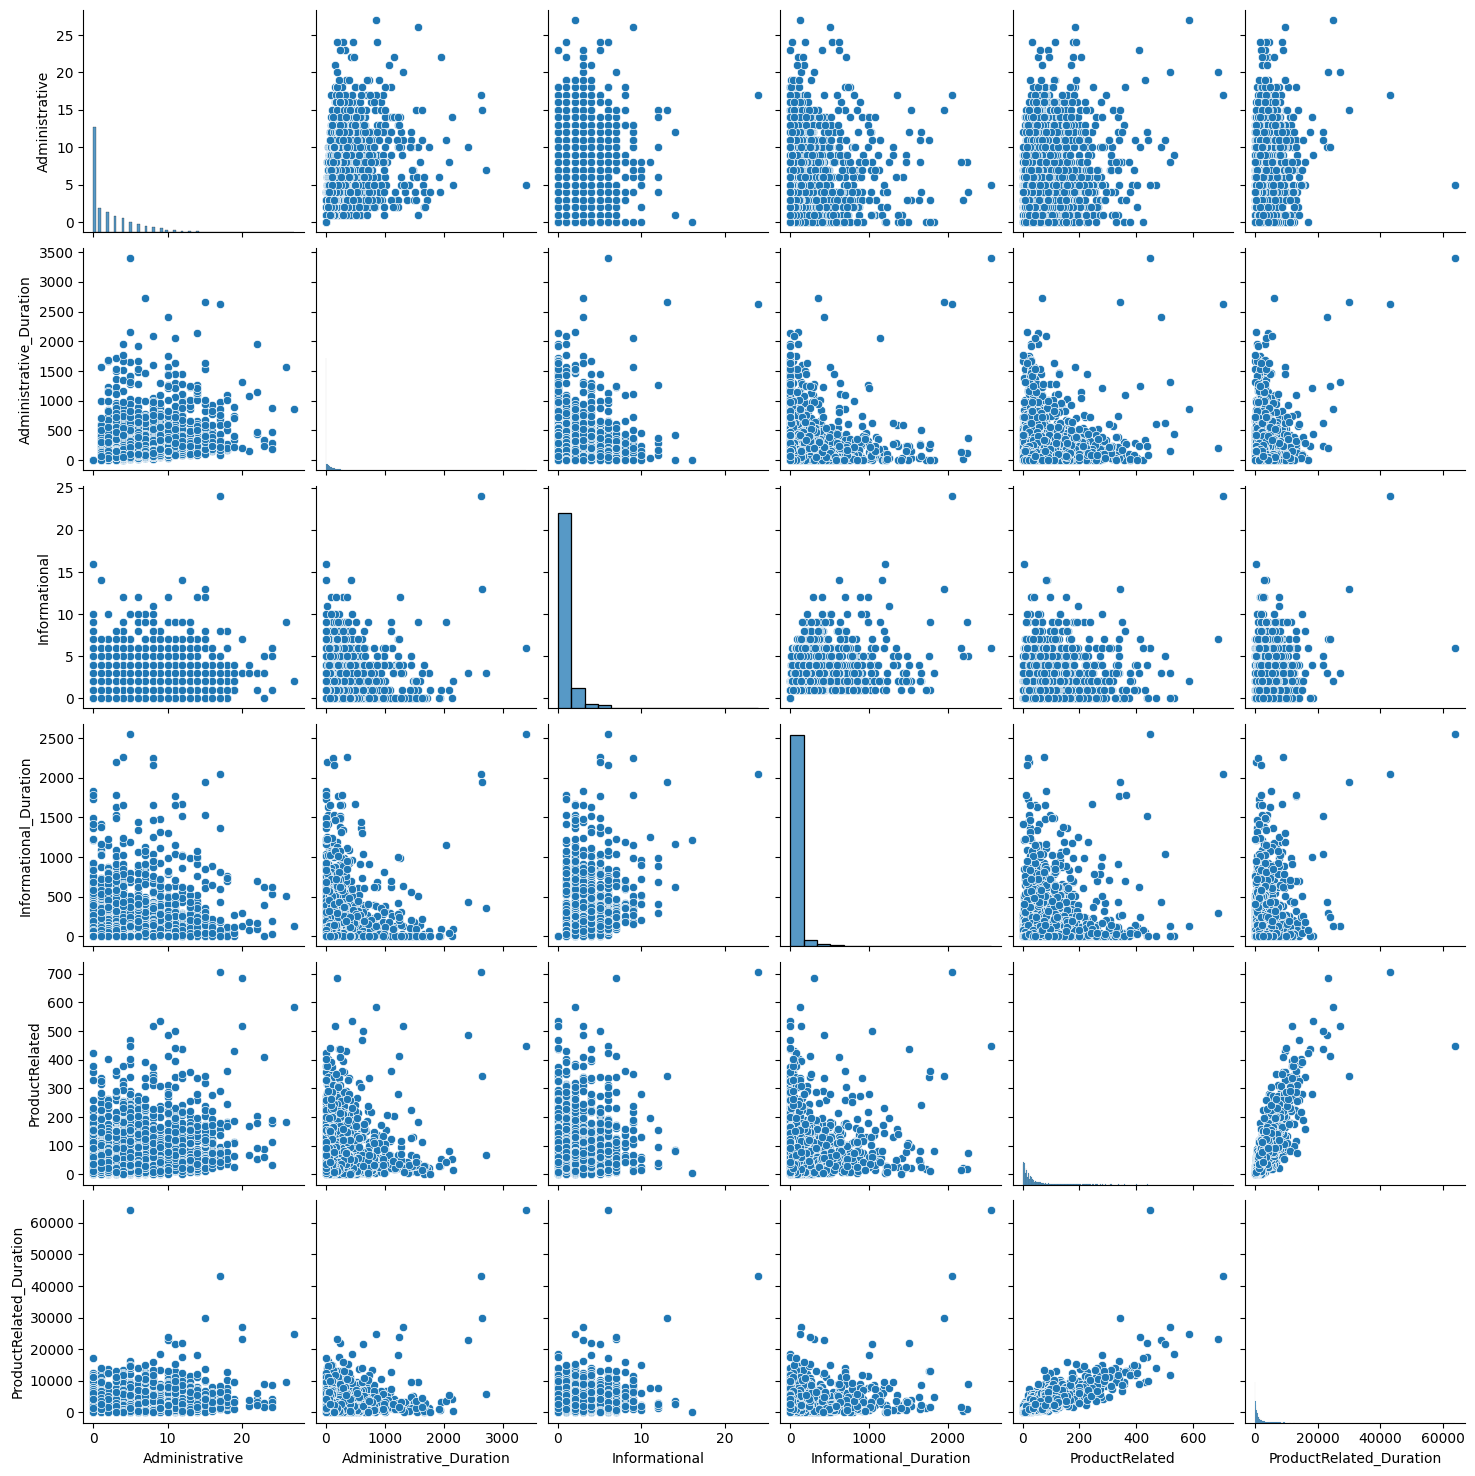

In [25]:
sns.pairplot(df[pagetypes])

The second set of features measure the customer's tendencies, or behavior , on the website. Customer tendencies such as total visits a customer makes before purchasing a product. This group of features contain percentage data like the first group of variables and will be observed alongside the date variables. The following values are recorded by Google Analytics:


bounce rate : percentage of customers that arrive at the site and exit without engaging or clicking on any of the contents. 

exit rate : the ratio of customers leaving from a specific webpage to the amount of views it gets.

page values : average amount visits to a page before a customer completes a purchase.

<Axes: >

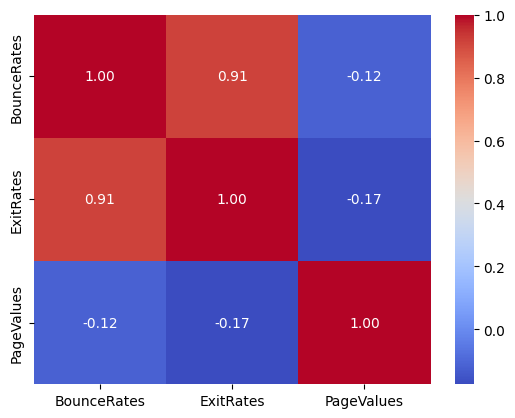

In [8]:
analytics = ['BounceRates', 'ExitRates', 'PageValues']
correlations = df[analytics].corr()
sns.heatmap(correlations, annot=True, cmap = 'coolwarm', fmt = '0.2f')


The third group of features are related to customer inormation such as operating systems, browser, region, 

In [ ]:
customers = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']